In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Data Storytelling**
This notebook dives deeper into data and tries to tell a story by means of visualizations.  
Data was cleaned in the previous data-wrangling exercise. Therefore, there are no outliers or missing values in the current data.

In [1]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import defaultdict

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [2]:
with open('../data/01-House-Price/wrangled_data.pkl','rb') as file:
    housing_orig, FEATURES = pickle.load(file)

In [3]:
housing = housing_orig.copy()
housing.head()

MSSubClass MSZoning  LotFrontage  LotArea Street    Alley LotShape  \
Id                                                                      
1          60       RL         65.0     8450   Pave  Missing      Reg   
2          20       RL         80.0     9600   Pave  Missing      Reg   
3          60       RL         68.0    11250   Pave  Missing      IR1   
4          70       RL         60.0     9550   Pave  Missing      IR1   
5          60       RL         84.0    14260   Pave  Missing      IR1   

   LandContour Utilities LotConfig  ... SaleType SaleCondition SalePrice  \
Id                                  ...                                    
1          Lvl    AllPub    Inside  ...       WD        Normal    208500   
2          Lvl    AllPub       FR2  ...       WD        Normal    181500   
3          Lvl    AllPub    Inside  ...       WD        Normal    223500   
4          Lvl    AllPub    Corner  ...       WD       Abnorml    140000   
5          Lvl    AllPub       FR2  ...       WD        Normal    250000   

   log1p(SalePrice) log1p(GrLivArea)        Lat        Lng  zipcode  \
Id                                                                    
1         12.247699         7.444833  42.022197 -93.651510  50010.0   
2         12.109016         7.141245  42.041304 -93.650302  50011.0   
3         12.317171         7.488294  42.022197 -93.651510  50010.0   
4         11.849405         7.448916  42.018614 -93.648898  50014.0   
5         12.429220         7.695758  42.053510 -93.648636  50010.0   

    median_household_income  median_home_value  
Id                                              
1                   48189.0           165300.0  
2                   48189.0           165300.0  
3                   48189.0           165300.0  
4                   37661.0           212500.0  
5                   48189.0           165300.0  

[5 rows x 87 columns]

# **Bivariate Analysis**

## **Numerical Data**

In [4]:
y = housing.SalePrice

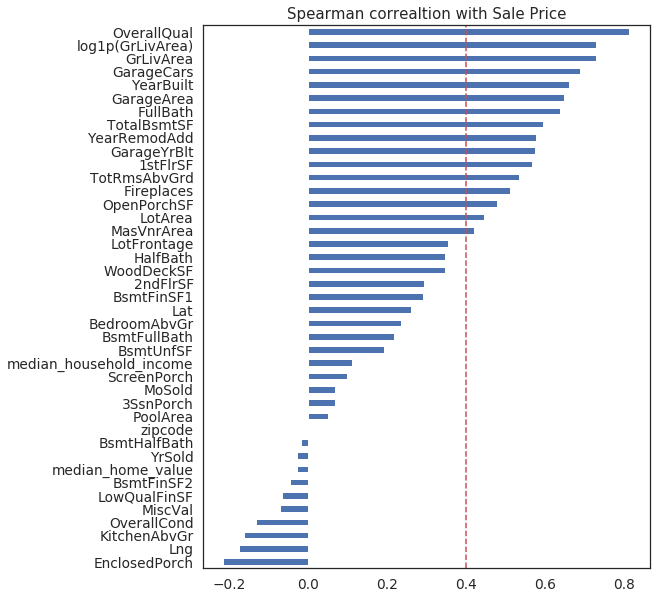

In [5]:
housing_num = housing[FEATURES['num']]
housing_num.corrwith(y,method='spearman').sort_values(ascending=True).plot.barh(figsize=(8,10),title = 'Spearman correaltion with Sale Price')
plt.axvline(x=0.4,linestyle='--',color='r')

In [7]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

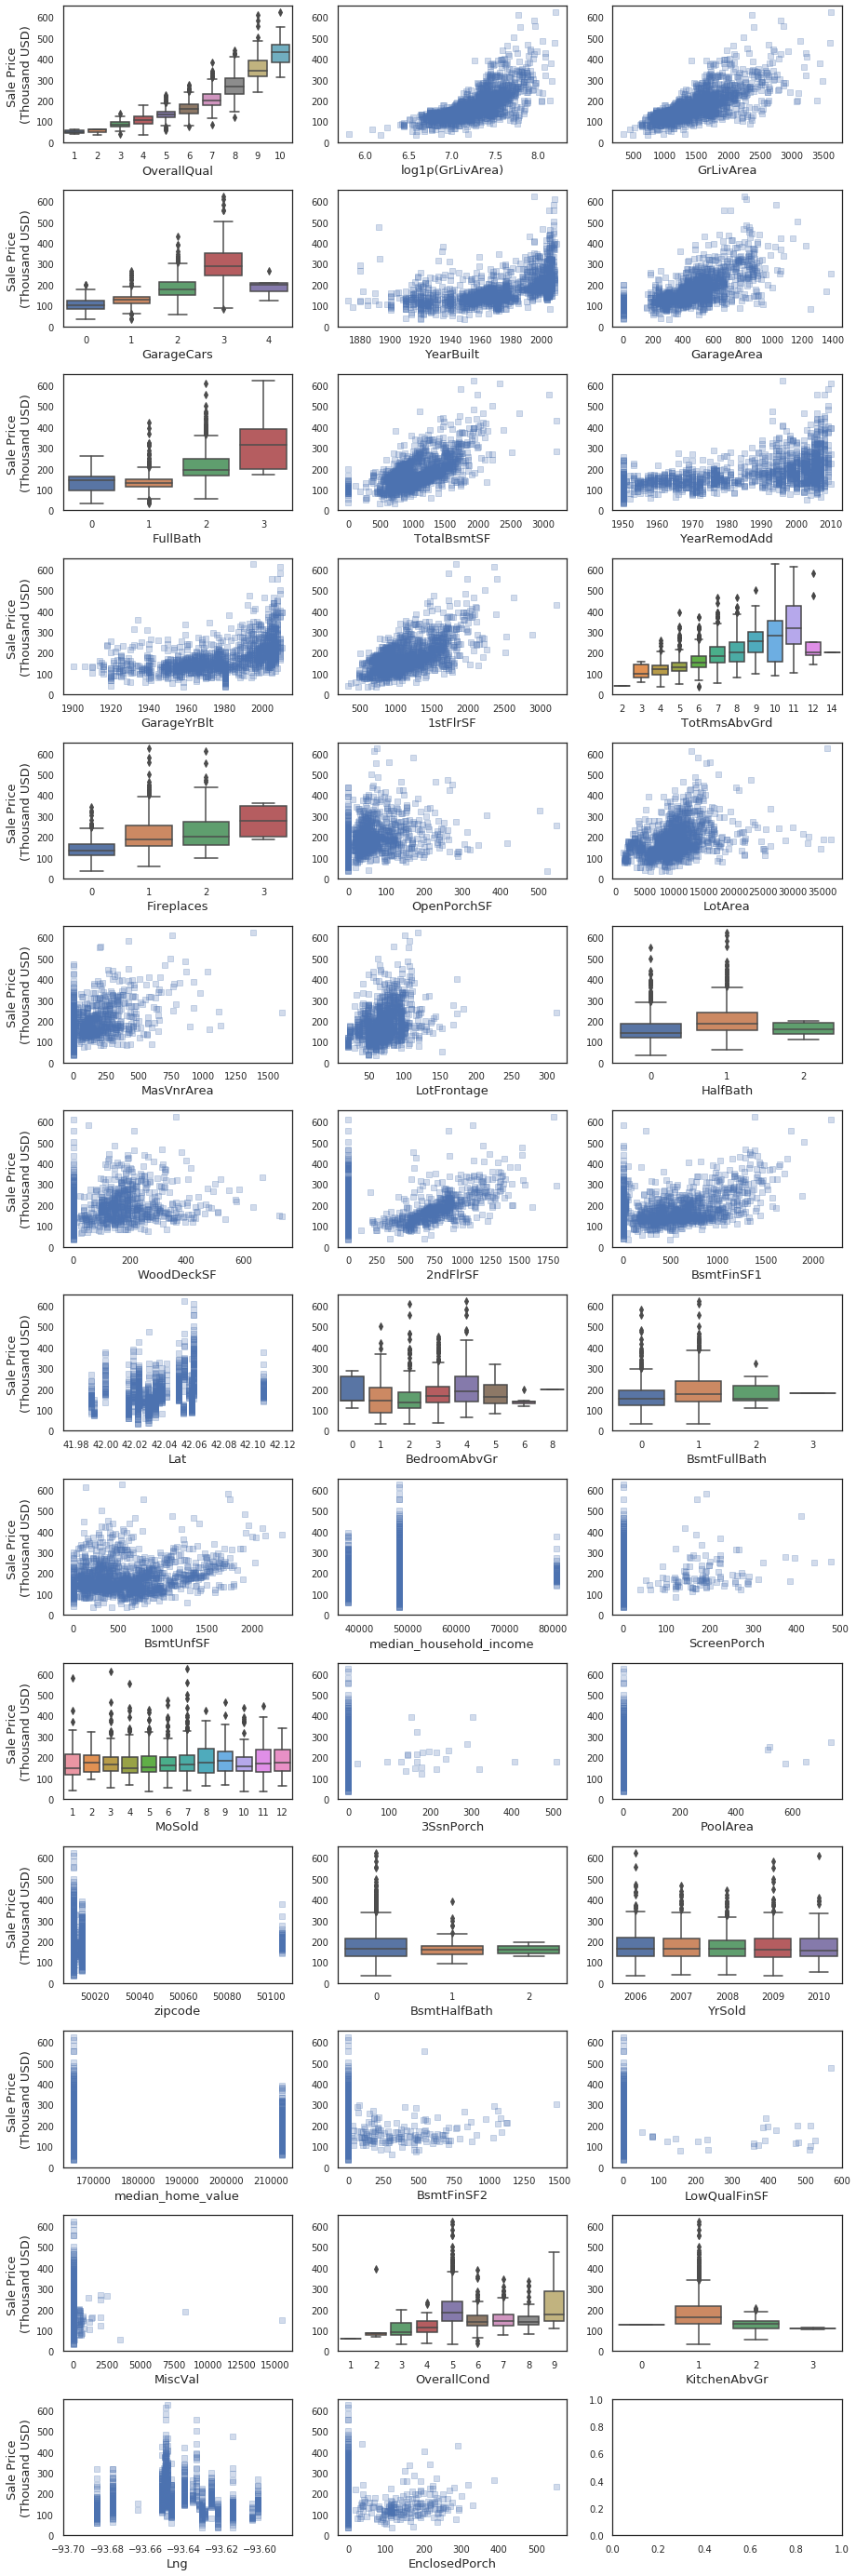

In [8]:
k_cols = 3
fig, axes = plt.subplots(ncols=k_cols,nrows=14,figsize=(15,50))
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()
yticks = np.arange(0,housing['SalePrice'].max()+1,100000)
yticklabs = [int(num) for num in np.arange(0,housing['SalePrice'].max()+1,100000)/1000]
for ii, feat in enumerate(housing_num.corrwith(y,method='spearman').sort_values(ascending=False).index):
    if feat in 'OverallQual MSSubClass OverallCond BsmtFullBath \
                BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr \
                Fireplaces GarageCars MoSold YrSold TotRmsAbvGrd'.split():
        
        if feat not in FEATURES['discrete']:
            FEATURES['discrete'].append(feat)
        sns.boxplot(x=feat,y='SalePrice',data=housing,ax=axes[ii])
    else:
        if feat not in FEATURES['cont']:
            FEATURES['cont'].append(feat)
        axes[ii].scatter(x=housing[feat],y=y,alpha=0.25,marker='s')
        
    if ii % k_cols != 0:
        axes[ii].set_ylabel('')
    else:
        axes[ii].set_ylabel('Sale Price \n(Thousand USD)',fontsize=13)

    axes[ii].set_yticks(ticks=yticks)
    axes[ii].set_yticklabels(labels=yticklabs)
    axes[ii].set_xlabel(feat,fontsize=13)
    

Comments/Observation:
- Following numercial features showed strong positve correlation (>= 0.4) with the sale price (listed in descending order of their correlation strength with sale price).
    - Overall Quality (**OverallQual**)
    - Above grade living area in sq. ft. (**GrLivArea**)
    - Total garage car capacity in number of cars (**GarageCars**)
    - Year built (**YrBuilt**)
    - Garage area in sq.ft (**GarageArea**)
    - Number of full bathrooms above grade (**FullBath**)
    - Total area of the basement in sq. ft. (**TotalBsmtSF**)
    - Year when the house of remodeled (**YearRemodAdd**) 
    - Garage year built (**GarageYrBlt**)
    - Area of the first floor in sq. ft.(**1stFlrSF**)
    - Total rooms above grade (**TotRmsAbvGrd**)
    - Number of fireplaces (**FirePlaces**)
    - Open porch area in sq. ft. (**OpenPorchSF**)
    - Lot Area in sq. ft. (**LotArea**)
    - Masonry veneer area in sq, ft. (**MasVnrArea**)

## **Categorical Data**

Anova on every categorical feature

In [9]:
from scipy import stats

In [10]:
housing_cat = housing[FEATURES['cat']]

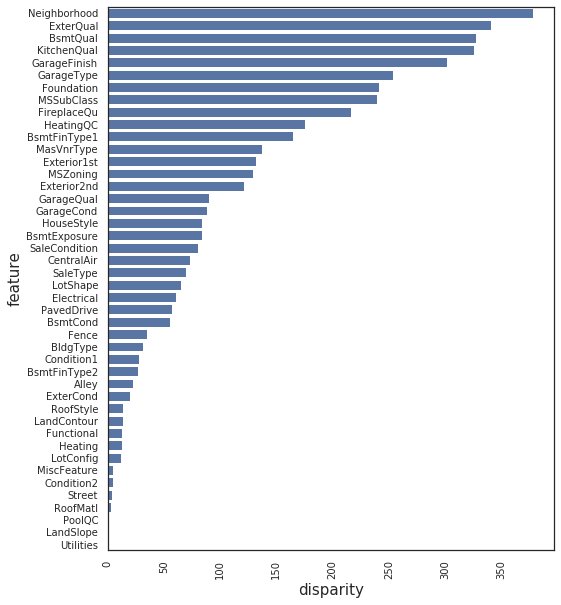

In [11]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = FEATURES['cat']
    pvals = []
    for c in FEATURES['cat']:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.kruskal(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval').reset_index(drop=True)

a = anova(housing_cat.join(y))
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(8,10))
sns.barplot(x='disparity',y='feature',data=a,color=sns.color_palette(n_colors=1)[0])
x=plt.xticks(rotation=90)

The above bar plot shows influence of each categorical feature on the sale price. Features with higher disparity have greater influence on the sale price.

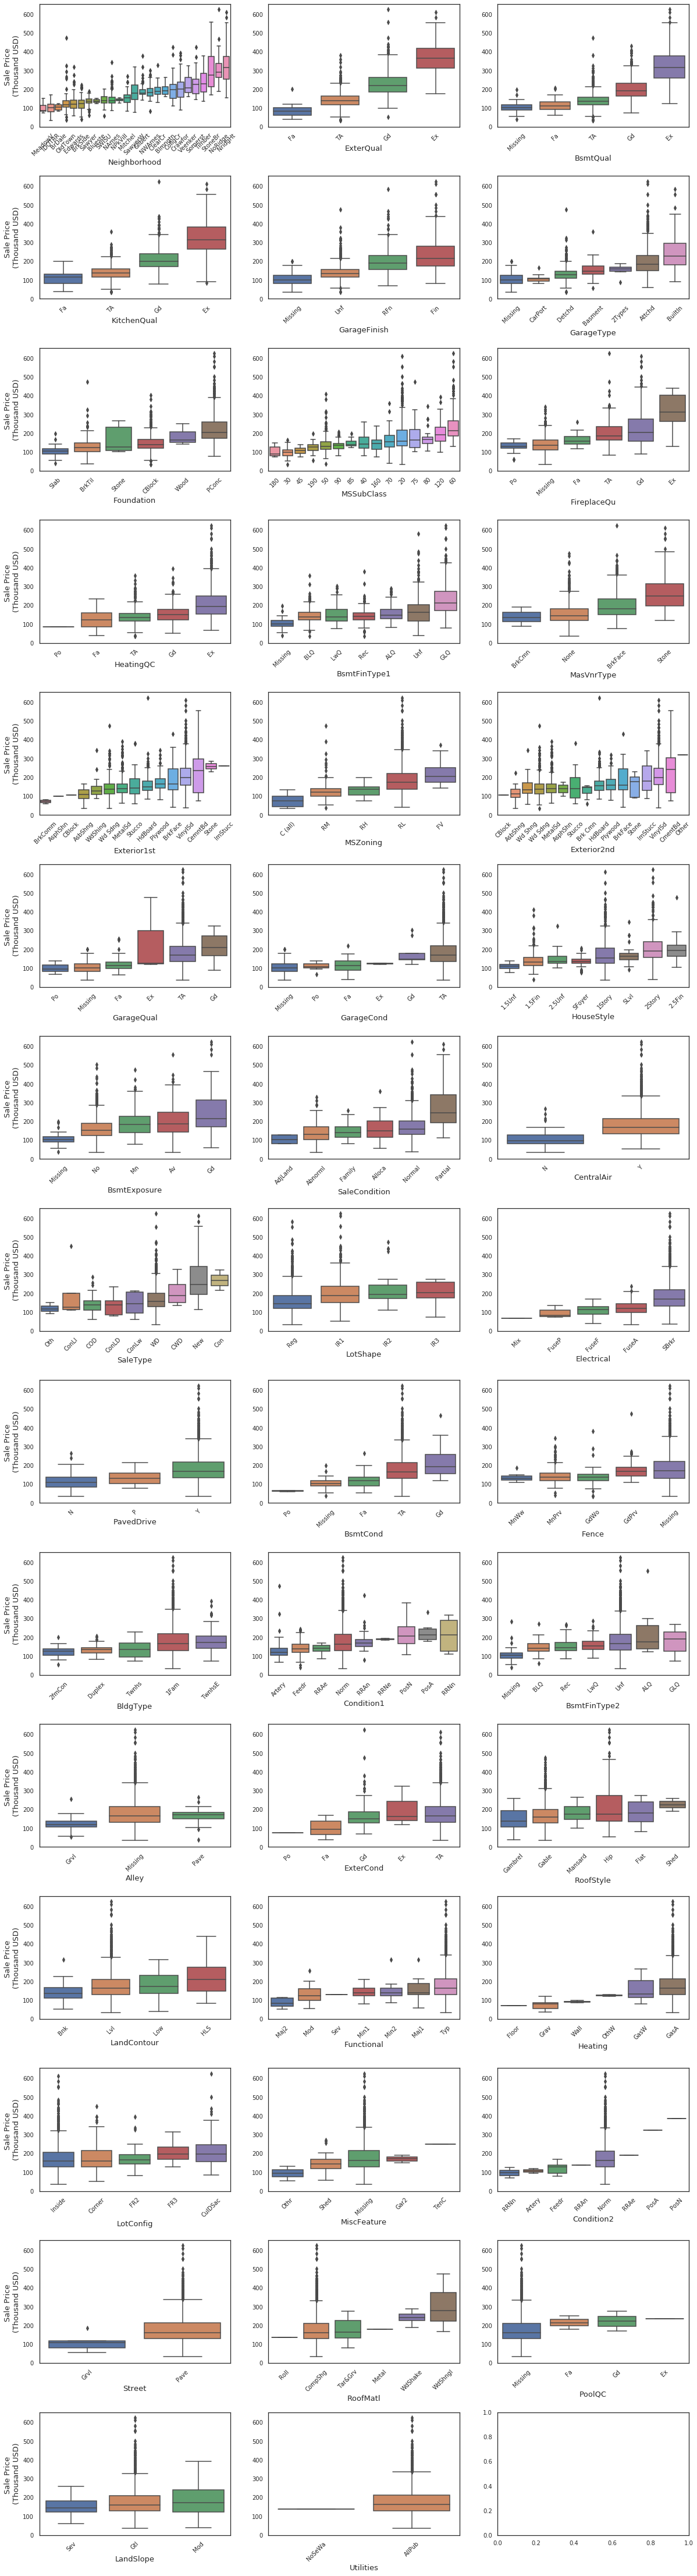

In [12]:
k_cols = 3
fig, axes = plt.subplots(ncols=k_cols,nrows=15,figsize=(20,80))
fig.subplots_adjust(hspace=0.4)
axes = axes.flatten()
yticks = np.arange(0,housing['SalePrice'].max()+1,100000)
yticklabs = [int(num) for num in np.arange(0,housing['SalePrice'].max()+1,100000)/1000]
for ii, feat in enumerate(a.feature):
    order = y.groupby(housing_cat[feat]).median().sort_values().index.to_list()
    sns.boxplot(x=feat,y='SalePrice',data=housing_cat.join(y),ax=axes[ii],order=order)
    
    if ii % k_cols != 0:
        axes[ii].set_ylabel('')
    else:
        axes[ii].set_ylabel('Sale Price \n(Thousand USD)',fontsize=13)

    axes[ii].set_yticks(ticks=yticks)
    axes[ii].set_yticklabels(labels=yticklabs)
    axes[ii].set_xlabel(feat,fontsize=13)
    
    for tick in axes[ii].get_xticklabels():
        tick.set_rotation(45)

Following are the top 10 categorical features that influence house price the most (listed in descending order of thier influence):

1. Neighborhood: Neighborhood has highest influence on house price
    - Houses located in **North Ridge** and **North Ridge Heights** have the highest median price
2. Quality of the exterior material (ExterQual)
    - Houses with **excellent** quality of external material tend to have higher price
3. Height of the basement (BsmtQual)
    - Houses with basement **heights > 100 inches** tend to have higher price
4. Kitchen Quality (KitchenQual)
    - **Better quality**, higher price
5. GarageFinish
    - Houses with garage that have **finished interior** have higher price
6. GarageType 
    - Houses with **built-in garage** have higher price
7. Foundation 
    - Houses with foundation made out of **poured concrete**
8. Type of dwelling involved in the sale (MSSubClass)
    - **2-STORY dwelling built in and after 1946** have higher price
9. Fireplace Quality (FireplaceQu)
    - Houses with **excellent** quality fireplace have higher price
10. Heating quality and condition (HeatingQC)
    - Houses with **excellent** quality heating and condition higher price

# **Multivariate Analysis**

### **Is there a relationship between Neighhood and Overall Quality?**
Neighborhood and Overall quality had the highest influence of the sale price. 

In [13]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [14]:
def cmap(n_cols):
    cmap = sns.color_palette("RdBu", n_colors=n_cols)[::-1]
    return cmap

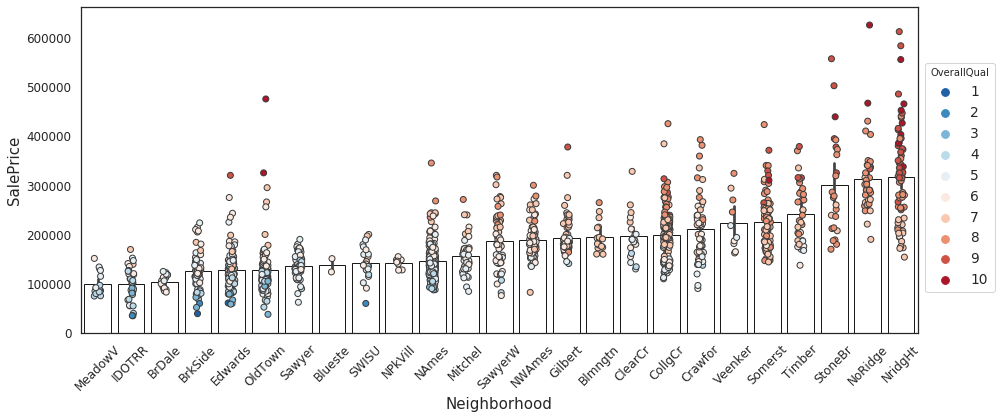

In [15]:
order = housing.groupby('Neighborhood')['SalePrice'].mean().sort_values().index
plt.figure(figsize=(15,6))
sns.barplot(x='Neighborhood',
            y='SalePrice',
            data=housing,
            order=order,
            color='white',
            edgecolor='k')
sns.stripplot(x='Neighborhood',
              y='SalePrice',
              data=housing,
              order=order,
              alpha=1,
              size=6,
              hue='OverallQual',
              palette=cmap(10),
              linewidth=1)
_=plt.xticks(rotation=45)
_=plt.legend(loc='upper right',bbox_to_anchor=(1.1,.85),title='OverallQual')

Observation:
- The barplot shows average house price per neighborhood. Bars are ordered in ascending order of the average house prices.
- We can broadly term neighborhoods to the right as "expensive" and those to left as "cheap."

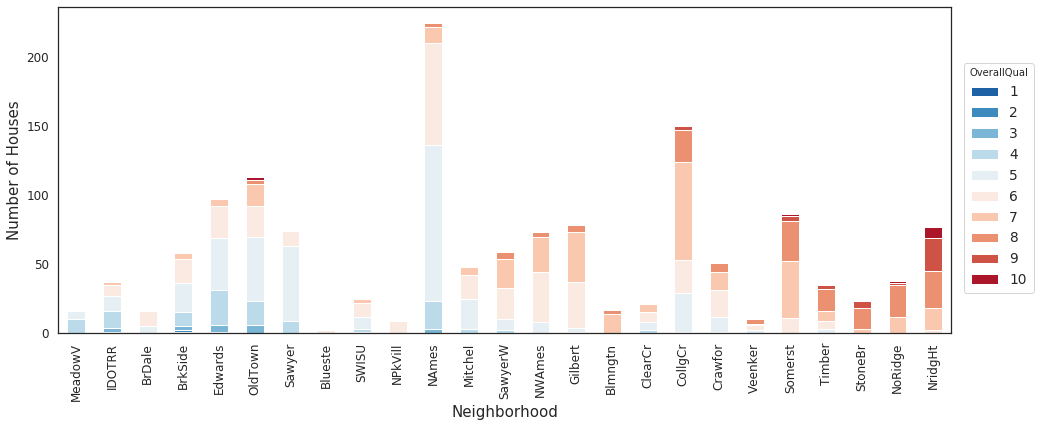

In [16]:
housing.groupby(['Neighborhood','OverallQual']).size().unstack('OverallQual').reindex(index=order).fillna(0).plot.bar(stacked=True,
                                                                                           color=cmap(10),
                                                                                           figsize=(16,6))
_=plt.ylabel('Number of Houses')
_=plt.legend(loc='upper right',bbox_to_anchor=(1.1,.85),title='OverallQual')

Observation: 
   - Highest concentration of better overall quality houses is found in **Northridge heights** (one of the expensive neighborhoods).

### **What is the average above grade living area of a houses in a particular neighborhood?**

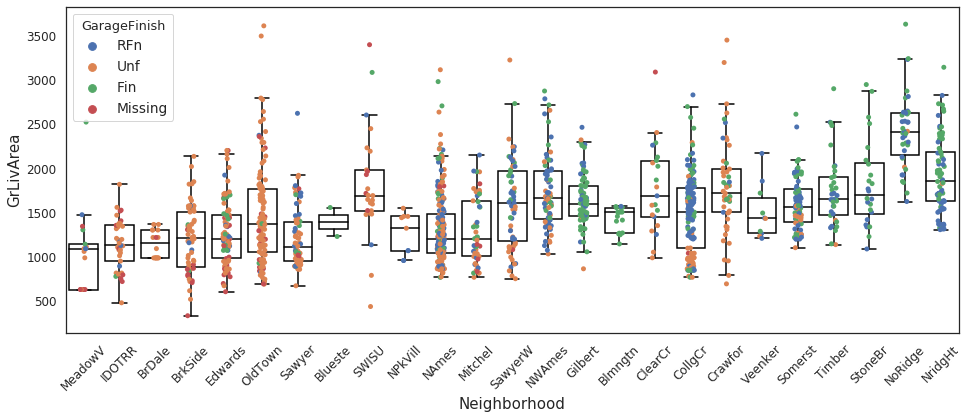

In [17]:
plt.figure(figsize=(16,6))
ax=sns.boxplot(x='Neighborhood',
               y='GrLivArea',
               data=housing,
               order=order,
               color='white',
               flierprops = dict(markersize = 0))
plt.xticks(rotation=45)
# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
            
sns.stripplot(x='Neighborhood',
              y='GrLivArea',
              data=housing,
              hue='GarageFinish',
              order=order)


Observation:
- Houses in expensive neighborhoods like **Northridge** and **Northridge Heights** have larger above grade living area.

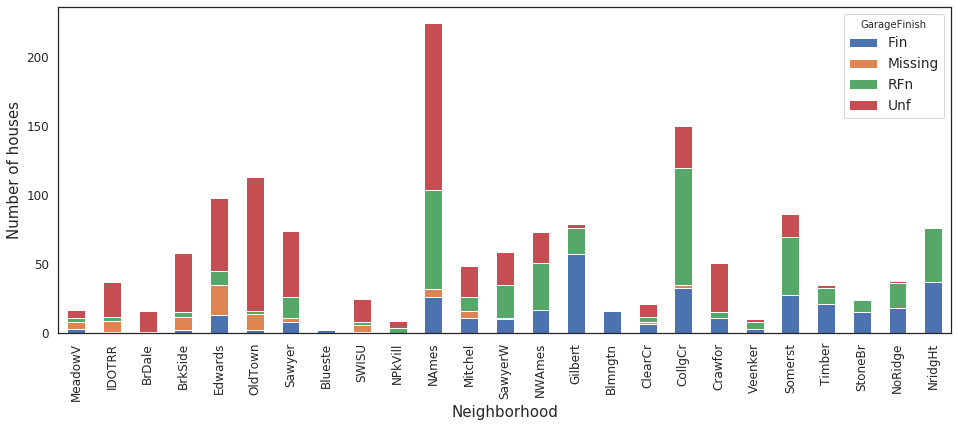

In [19]:
housing.groupby(['Neighborhood','GarageFinish'])['GarageFinish'].size().unstack('GarageFinish').fillna(0).reindex(index=order).fillna(0).plot.bar(stacked=True,
                                                                                                                                                  color=sns.color_palette(n_colors=4),
                                                                                                                                                  figsize=(16,6))
_=plt.ylabel('Number of houses')

Observation:
- Almost all houses in expensive neighborhoods like **Northridge** and **Northridge Heights** either have a **finished** or a **roughly finished** garage.  
- Houses with no or **un-finished** garage are very common in neighborhoods like **North Ames**, **Old Town**.

### **What types of garage are most prevalent in different neighborhoods?**

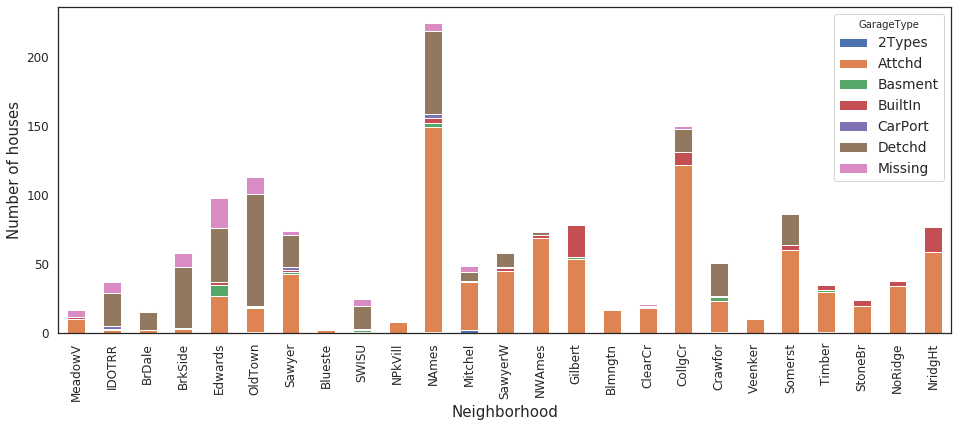

In [20]:
housing.groupby(['Neighborhood','GarageType'])['GarageType'].size().unstack('GarageType').fillna(0).reindex(index=order).fillna(0).plot.bar(stacked=True,
                                                                                                                                                  color=sns.color_palette(n_colors=7),
                                                                                                                                                  figsize=(16,6))
_=plt.ylabel('Number of houses')

Obsevation:
- Generally houses with **attached** garage are most prevalent across neighborhoods.
- Besides attached garage, houses with **built-in** garage are most prevalent in moderately expensive (**Gilbert**, **College Creek**) and expensive neighborhoods (**Northridge Heights**, **Northrigde** and **Stone Brook**)
- Houses in cheaper neighborhoods mostly have detached garage, followed by detached garage or no garage at all.

In [21]:
palette = sns.color_palette()

### **In what year highest number of houses were built?**

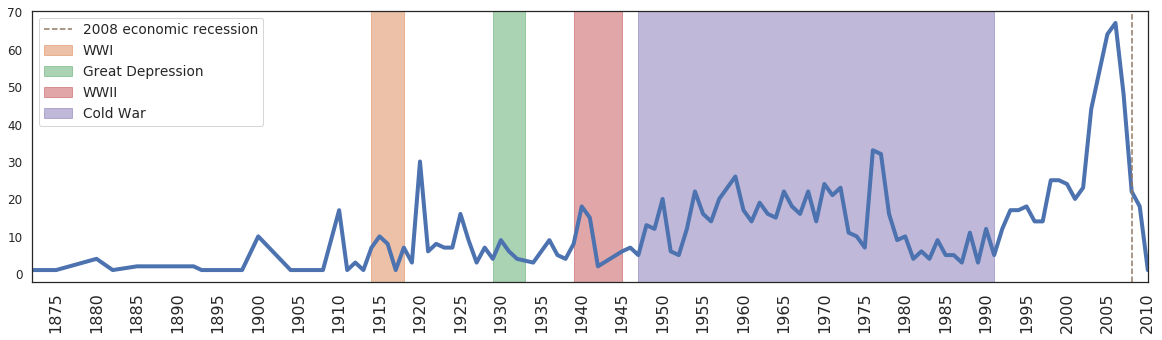

In [22]:
plt.figure(figsize=(20,5))
ax = housing.YearBuilt.value_counts().sort_index().plot(linewidth=4,label = '')
_=plt.axvspan(xmin=1914,xmax=1918,color=palette[1],alpha=0.5,label = 'WWI')
_=plt.axvspan(xmin=1929,xmax=1933,color=palette[2],alpha=0.5,label ='Great Depression')
_=plt.axvspan(xmin=1939,xmax=1945,color=palette[3],alpha=0.5,label ='WWII')
_=plt.axvspan(xmin=1947,xmax=1991,color=palette[4],alpha=0.5,label='Cold War')
_=plt.axvline(x=2008,linestyle='--', label = '2008 economic recession',color=palette[5])
_=plt.xticks(np.arange(1875,2011,5),rotation = 90,fontsize=16)
_=plt.legend()

Comments/Observation:

Certain years have been shaded to highlight important historic events that took place during those times; it's just meant to give a histrical context.

- After 1990 (which is also the time when Cold War ended and United States' economy boomed), we observe an increase in the number of houses being built in Ames, IA.
- However in 2006, the number peaked and started falling steeply. 

### **Generally after how many years is a house remodeled?**

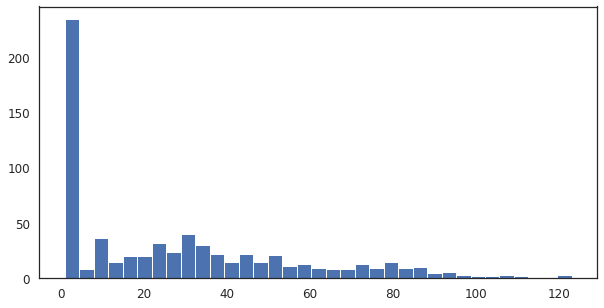

In [23]:
remod_after = housing.YearRemodAdd - housing.YearBuilt
remod_after = remod_after[remod_after > 0]
plt.figure(figsize=(10,5))
_=plt.hist(remod_after,bins=35)

Comments/Observation:
- Most houses are remodeled within the first couple of years after they are built.

### **In which year most of the houses were sold?**

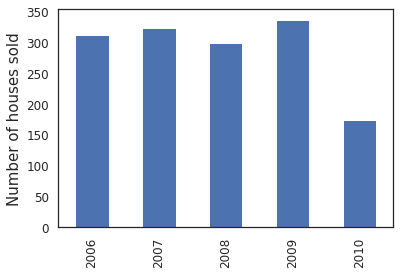

In [24]:
ax = housing.YrSold.value_counts().sort_index().plot.bar()
_=plt.ylabel('Number of houses sold')

Comments/Observation:

- All houses were sold between 2006 and 2010 (highest in 2009). 
- Recall this is also the time when number of houses built declined. 

### **Is there a particular time of the year when people choose to buy a house?**

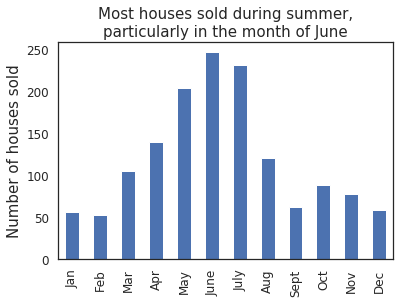

In [25]:
ax = housing.MoSold.value_counts().sort_index().plot.bar(title = 'Most houses sold during summer,\nparticularly in the month of June')
_=plt.xticks(ticks=ax.get_xticks(),labels=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'])
_=plt.ylabel('Number of houses sold')

Comments/Observation:
- Most houses are bougth during the summer, highest being in the month of June.

### **Do house prices fluctuate across the year?**

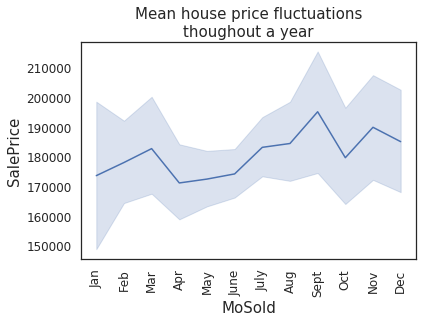

In [26]:
ax = sns.lineplot(x='MoSold',y='SalePrice',data=housing,color=palette[0],)
_=plt.xticks(np.arange(1,13),labels=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'])
_=plt.title('Mean house price fluctuations\nthoughout a year')
_=plt.xticks(rotation=90)

Comments/Observation:
- House prices fall by a few thousand dollars (~$10,000 dollars) by the end of winter (in Apr) and start rising back up by May. This explains why most houses are bought during summer.

### **House zoning in different neighborhoods**

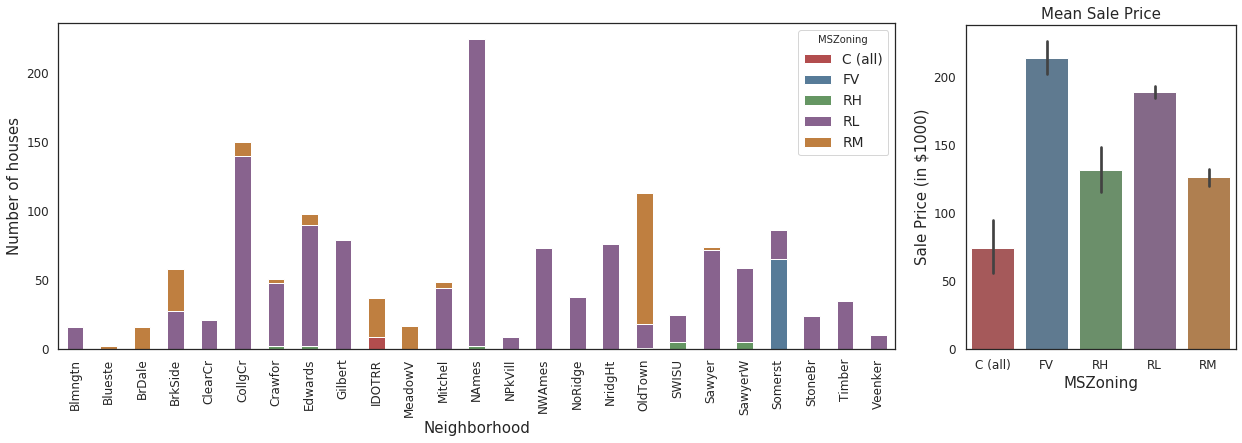

In [28]:
housing.groupby(['Neighborhood','MSZoning']).size().unstack('MSZoning').fillna(0).plot.bar(stacked=True,
                                                                                           color=sns.color_palette("Set1", n_colors=5, desat=.5),
                                                                                           figsize=(15,6))
plt.ylabel('Number of houses')
plt.axes([.965,0.125,0.25,0.75])
sns.barplot(x='MSZoning',y='SalePrice',
            data=housing,
            palette=sns.color_palette("Set1", n_colors=5, desat=.5),
            order=['C (all)','FV','RH','RL','RM'])
_=plt.yticks(ticks=np.arange(0,250000,50000),
           labels=[int(num) for num in np.arange(0,250000,50000)/1000])
_=plt.ylabel('Sale Price (in $1000)')
_=plt.title('Mean Sale Price')

Conclusion:
- Most houses are located in a **low density residential (RL)** zone across majority neighbohoods.
- In **Somerst**, most houses are located in the **floating village (FV)** residential zone. Note: houses in this zone also have the highest average price.
- Only in **Iowa DOT and Rail Road (IDOTRR)** neighborhood do we find houses located in **commerial (C all)** zones. Note: houses in this zone the lowest average price.
- Houses located in **floating village residential (FV)** zone are most expensive, whereas those locate in the **commercial** zones are cheapest.

### **Is the size of the housing property influenced by zoning?**

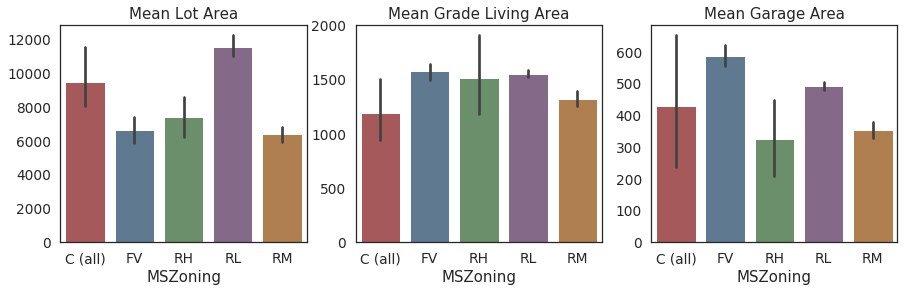

In [447]:
plt.figure(figsize=(15,4))
plt.subplots_adjust(hspace=0.40)

plt.subplot(1,3,1)
sns.barplot(x='MSZoning',y='LotArea',
            data=housing,
            palette=sns.color_palette("Set1", n_colors=5, desat=.5),
            order=['C (all)','FV','RH','RL','RM'])
_=plt.ylabel('')
_=plt.title('Mean Lot Area')

plt.subplot(1,3,2)
sns.barplot(x='MSZoning',y='GrLivArea',
            data=housing,
            palette=sns.color_palette("Set1", n_colors=5, desat=.5),
            order=['C (all)','FV','RH','RL','RM'])
_=plt.ylabel('')
_=plt.title('Mean Grade Living Area')

plt.subplot(1,3,3)
sns.barplot(x='MSZoning',y='GarageArea',
            data=housing,
            palette=sns.color_palette("Set1", n_colors=5, desat=.5),
            order=['C (all)','FV','RH','RL','RM'])
_=plt.ylabel('')
_=plt.title('Mean Garage Area')

Conclusion:
- Houses in **low density residential (RL)** zones have the largest average **Lot Area**. 
- Houses in **floating village residential (FV)** zone have the largest average **Garage Area**.

### **What is the most commom building-type and housing-style for houses in Ames?**

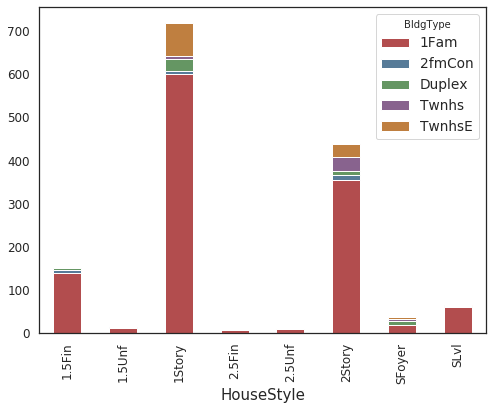

In [33]:
housing.groupby(['BldgType','HouseStyle']).size().unstack('BldgType').fillna(0).plot.bar(stacked=True,
                                                                                           color=sns.color_palette("Set1", n_colors=5, desat=.5),
                                                                                           figsize=(8,6))

Conclusion:

- Single family detached (**1Fam**) buiding type and 1 Story houses (**1Story**) house style are most common.